#### Problem 1

(100 points) Consider the following problem. <br>

$$
\begin{aligned}
\min_{x_1,x_2} & \quad f({\bf x})=x_1^2+(x_2-3)^2\\
{\text{subject to }} & \quad g_1 = x_2^2-2x_1\leq 0\\
                     & \quad g_2 = (x_2-1)^2+5x_1-15\leq 0
\end{aligned}
$$

Implement an SQP algorithm with line search to solve this problem, starting from ${\bf x}_0=(1,1)^T$. Incorporate the QP subproblem. Use BFGS approximation for the Hessian of the Lagrangian. Use the merit function and Armijo Line Search to find the step size.

---

#### Solution

------------------------------------------------------------
	Sequential Quadratic Programming (SQP) method
------------------------------------------------------------
Number of iterations: 199
Error (norm of Largangian gradient): 7.365333388402817
Min function value: f(x*) = [3.50746807]
The solution to the minimization problem is: 
x* = [[1.06019885]
 [1.45615854]]
------------------------------------------------------------



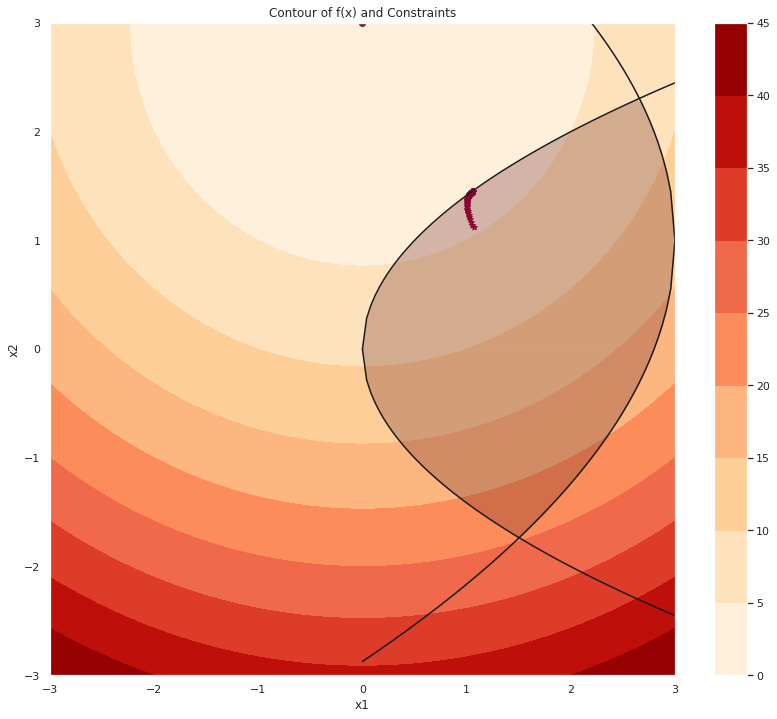

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers


def f(x):
    """The objective function."""
    return x[0]**2 + (x[1]-3)**2

def df(x):
    """The gradient of the objective function."""
    return np.array([2*x[0], 2*(x[1]-3)])


def g(x):
    """The problem inequality constraints g_i(x)<=0."""
    return np.array([x[1]**2-2*x[0], 
                     (x[1]-1)**2+5*x[0]-15])

def dg(x):
    """The gradient of the inequality constraints."""
    return np.array([[-2, 2*x[1][0]], 
                     [5, 2*(x[1][0]-1)]])
    
def sqp(f, df, g, dg, x0, eps, max_iter):

    x = x0.reshape((2,1)) # Set current solution to the initial guess
    solution_history = []
    
    # Initializations 
    W = np.eye(len(x))                           # Hessian 
    mu_old = np.zeros(g(x).shape)                # Lagrange multipliers
    w = np.zeros(g(x).shape)                     # Weights of merit function
    gnorm = np.linalg.norm(df(x) + np.dot(mu_old.T,dg(x))) # Termination criterion: Norm of the Largangian gradient
    i = 0                                        # Current iteration

    while gnorm > eps and i < max_iter:

        # Solve the QP subproblem
        P = matrix(W, tc='d')
        q = matrix(df(x), tc='d')
        G = matrix(dg(x), tc='d')
        h = matrix(-g(x), tc='d')
        sol = solvers.qp(P,q,G,h, options={'show_progress': False})
        s = np.array(sol['x'])
        mu_new = np.array(sol['z'])
        # print('s', s)
        # print('mu_new', mu_new)

        a = 0.1
        # Update the current solution 
        dx = a*s               # Step for x
        x = x + dx             # Update x using the step
        
        # Update Hessian using BFGS 
        # -------------------------
        # Compute y_k
        y_k = df(x) + np.dot(mu_new.T,dg(x)).T - df(x-dx) - np.dot(mu_new.T,dg(x-dx)).T
        # Compute theta
        if np.dot(dx.T,y_k) >= 0.2*np.linalg.multi_dot([dx.T,W,dx]):
            theta = 1
        else:
            theta = (0.8*np.linalg.multi_dot([dx.T,W,dx]))/(np.linalg.multi_dot([dx.T,W,dx])-np.dot(dx.T,y_k))
        # Compute dg_k
        dg_k = theta*y_k + (1-theta)*W*dx
        # Compute new Hessian
        W = W + np.dot(dg_k,dg_k.T)/np.dot(dg_k.T,dx) - (np.dot(W,dx)*np.dot(W,dx).T)/np.linalg.multi_dot([dx.T,W,dx])

        # Update values
        gnorm = np.linalg.norm(df(x) + np.dot(mu_new.T,dg(x)))
        mu_old = mu_new
        i += 1

        # Save current solution
        solution_history.append(x)
    
    # Display the solution
    print('-'*60+'\n\tSequential Quadratic Programming (SQP) method\n'+'-'*60)
    print('Number of iterations: {}'.format(i-1))
    print('Error (norm of Largangian gradient): {}'.format(gnorm))
    print('Min function value: f(x*) = {}'.format(f(x)))
    print('The solution to the minimization problem is: \nx* = {}'.format(x))
    print('-'*60 + '\n')

    return solution_history


def plot_sol(f, sol):
    """Plots objective function contour, constraints and solution."""
    
    # Create mesh
    x1 = np.linspace(-3,3,149)
    x2 = np.linspace(-3,3,149)
    X1, X2 = np.meshgrid(x1, x2)
    Z = f([X1, X2])

    # Contour
    fig, ax = plt.subplots(figsize = (14,12))
    plt.contourf(X1,X2,Z,10, cmap='OrRd')
    ax.set(xlabel='x1', ylabel='x2')
    ax.set_title('Contour of f(x) and Constraints')
    plt.colorbar()
    # Constraints    
    x1_pos = x1[x1.shape[0]//2:]
    y1 = np.sqrt(2*x1_pos)
    ax.plot(x1_pos, y1, x1_pos, -y1, color='k')

    x2_pos = x2[x2.shape[0]//2:]
    y2a = np.sqrt(15-5*x1_pos) + 1
    y2b = -np.sqrt(15-5*x1_pos) + 1
    ax.plot(x2_pos, y2a, x2_pos, y2b, color='k')
    # Feasible domain       
    y3 = np.minimum(y1,y2a)
    y4 = np.maximum(-y1,y2b)
    y5 = np.maximum(0,y2b)
    plt.fill_between(x1_pos, y3, y5, color='#702c2c', linewidth=0.0, alpha=0.3) 
    plt.fill_between(x1_pos, y4, where=y4<=0, color='#702c2c', linewidth=0.0, alpha=0.3)
    # Unconstrained Optimum 
    ax.plot(0, 3, 'o', color='#702c2c') 

    # Solutions 
    x1 = np.array([s[0] for s in sol])
    x2 = np.array([s[1] for s in sol])
    ax.scatter(x1, x2, color = '#8b0733', marker = '*')

    ax.set_ylim([-3, 3])
    plt.show()


if __name__ == "__main__":

    # Parameters
    # --------------------------------------------------------------------------
    epsilon = 1e-3          # Tolerance (termination criterion)
    max_iterations = 200    # Maximum iterations before halting    
    x0 = np.array([1, 1])   # Initial guess that satisfies the constraints g<=0

    # Feasibility check for the initial point
    if np.max(g(x0)>0):
        print('Infeasible initial point! You need to start from a feasible one!')

    # Solve minimization problem with SQP method
    # --------------------------------------------------------------------------
    solutions = sqp(f, df, g, dg, x0, epsilon, max_iterations)

    plot_sol(f, solutions)
    